In [ ]:
# Bayesian Regression for Noisy Sensor Data

**Author:** Md. Hasanul Kabir  
**Affiliation:** School of Computer Science and Technology, Nanjing Normal University  
**Date:** [Nov 2, 2025]

---

### Abstract
This notebook demonstrates how Bayesian Linear Regression can be used to model and quantify uncertainty in noisy sensor measurements. 
We simulate a range sensor with bias and distance-dependent noise, then use Bayesian inference to estimate the calibration curve and its confidence intervals.


In [6]:
# Step 1: Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
from sklearn.linear_model import LinearRegression
import os

# Step 2: Create necessary folders
os.makedirs("../data", exist_ok=True)
os.makedirs("../figures", exist_ok=True)

# Step 3: For reproducibility
np.random.seed(42)


In [7]:
# Step 4: Generate simulated dataset
true_cm = np.repeat([10, 20, 30, 40, 50, 60, 80], repeats=20)  # true distances

# Hidden ground-truth sensor behavior
a_actual = 1.05    # scaling error
b_actual = 2.0     # constant bias

# Distance-dependent noise function
def noise_sigma(d): 
    return 0.5 + 0.03 * d  # more noise at longer distances

noise = np.random.normal(0, noise_sigma(true_cm))
measured_cm = a_actual * true_cm + b_actual + noise

# Create dataframe
data = pd.DataFrame({"true_cm": true_cm, "measured_cm": measured_cm})
data.to_csv("../data/sensor_readings.csv", index=False)

print("✅ Sensor data saved to '../data/sensor_readings.csv'")
data.head()



✅ Sensor data saved to '../data/sensor_readings.csv'


,true_cm,measured_cm
0,10,12.897371
1,10,12.389389
2,10,13.018151
3,10,13.718424
4,10,12.312677


In [8]:
# Step 4: Generate simulated dataset
true_cm = np.repeat([10, 20, 30, 40, 50, 60, 80], repeats=20)  # true distances

# Hidden ground-truth sensor behavior
a_actual = 1.05    # scaling error
b_actual = 2.0     # constant bias

# Distance-dependent noise function
def noise_sigma(d): 
    return 0.5 + 0.03 * d  # more noise at longer distances

noise = np.random.normal(0, noise_sigma(true_cm))
measured_cm = a_actual * true_cm + b_actual + noise

# Create dataframe
data = pd.DataFrame({"true_cm": true_cm, "measured_cm": measured_cm})
data.to_csv("../data/sensor_readings.csv", index=False)

print("✅ Sensor data saved to '../data/sensor_readings.csv'")
data.head()


✅ Sensor data saved to '../data/sensor_readings.csv'


,true_cm,measured_cm
0,10,12.681968
1,10,13.545714
2,10,11.214013
3,10,12.647707
4,10,12.707906


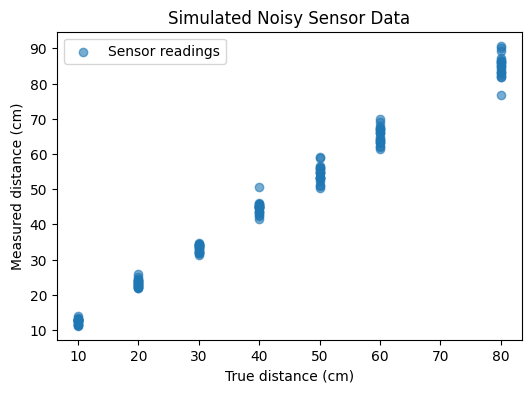

In [9]:
plt.figure(figsize=(6,4))
plt.scatter(data["true_cm"], data["measured_cm"], alpha=0.6, label="Sensor readings")
plt.xlabel("True distance (cm)")
plt.ylabel("Measured distance (cm)")
plt.title("Simulated Noisy Sensor Data")
plt.legend()
plt.show()


OLS slope = 1.038
OLS intercept = 2.493


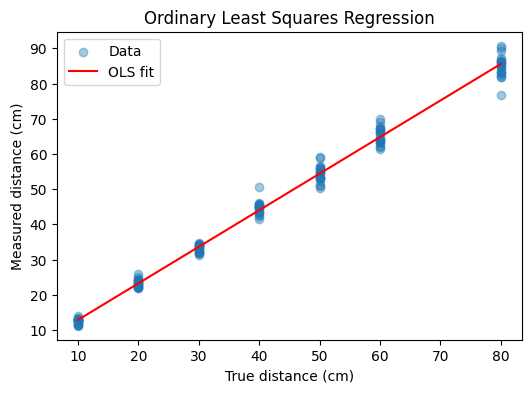

In [10]:
# Step 5: Fit simple linear regression
X = data["true_cm"].values.reshape(-1, 1)
Y = data["measured_cm"].values

ols = LinearRegression()
ols.fit(X, Y)

print(f"OLS slope = {ols.coef_[0]:.3f}")
print(f"OLS intercept = {ols.intercept_:.3f}")

# Step 6: Plot OLS result
x_line = np.linspace(X.min(), X.max(), 100)
y_line = ols.predict(x_line.reshape(-1, 1))

plt.figure(figsize=(6,4))
plt.scatter(X, Y, alpha=0.4, label="Data")
plt.plot(x_line, y_line, 'r', label="OLS fit")
plt.xlabel("True distance (cm)")
plt.ylabel("Measured distance (cm)")
plt.title("Ordinary Least Squares Regression")
plt.legend()
plt.show()


In [12]:
# Load dataset again to be safe
data = pd.read_csv("../data/sensor_readings.csv")

# Define predictor (X) and target (Y)
X = data["true_cm"].values.reshape(-1, 1)
Y = data["measured_cm"].values



In [13]:
# Step 7: Build Bayesian model
with pm.Model() as model:
    # Priors for slope, intercept, noise
    a = pm.Normal("a", mu=0, sigma=10)
    b = pm.Normal("b", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=5)
    
    # Linear model
    mu = a * X.flatten() + b
    
    # Likelihood (observed data)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=Y)
    
    # Posterior sampling
    trace = pm.sample(2000, tune=1000, target_accept=0.9, random_seed=42)



Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.038,0.008,1.024,1.052,0.000,0.000,3260.0,3204.0,1.0
b,2.502,0.363,1.837,3.197,0.006,0.005,3327.0,3512.0,1.0
sigma,2.026,0.124,1.809,2.269,0.002,0.002,3953.0,3922.0,1.0


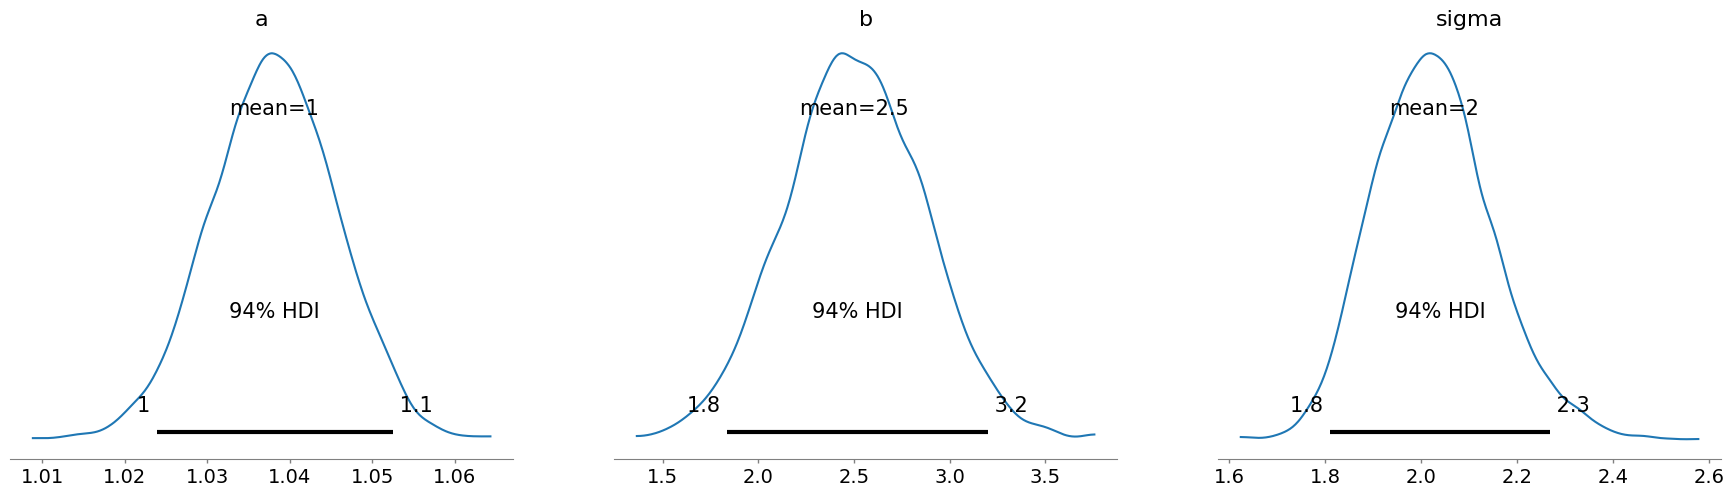

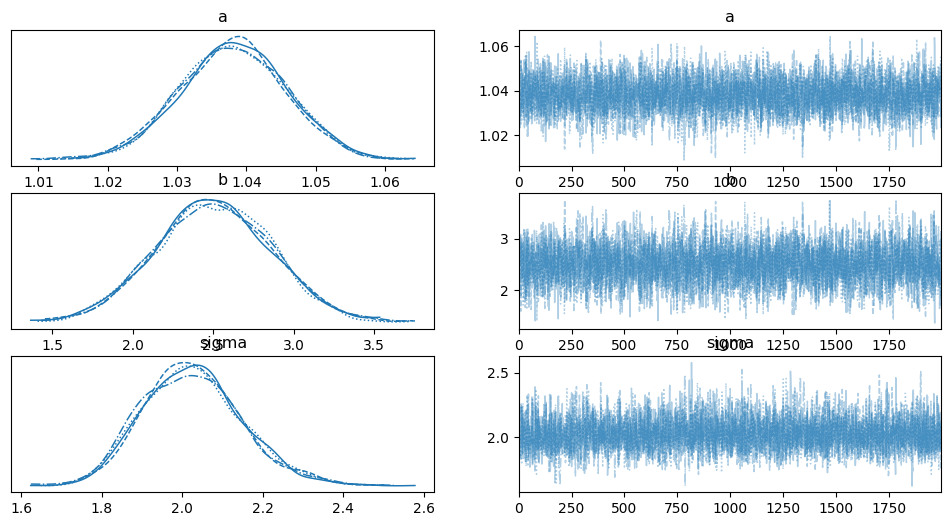

In [15]:
# Step 8: Print summary
summary = az.summary(trace, var_names=["a","b","sigma"])
display(summary)

# Step 9: Plot posterior distributions
az.plot_posterior(trace, var_names=["a","b","sigma"])
plt.show()

# Optional: Traceplot for convergence check
az.plot_trace(trace, var_names=["a","b","sigma"])
plt.show()


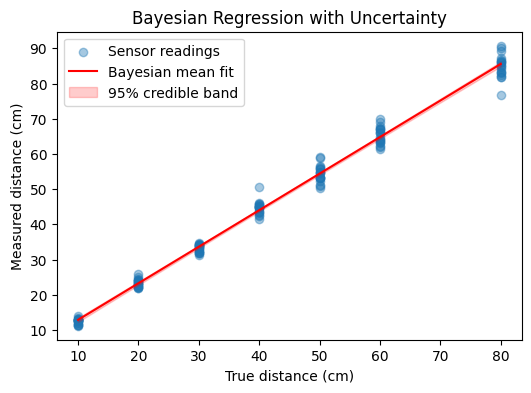

In [14]:
# Step 10: Predict for new distances
X_test = np.linspace(X.min(), X.max(), 100)

a_samples = trace.posterior["a"].values.flatten()
b_samples = trace.posterior["b"].values.flatten()

pred_samples = np.array([a_s * X_test + b_s for a_s, b_s in zip(a_samples, b_samples)])
pred_mean = pred_samples.mean(axis=0)
pred_low = np.percentile(pred_samples, 2.5, axis=0)
pred_high = np.percentile(pred_samples, 97.5, axis=0)

# Step 11: Plot final fit with uncertainty band
plt.figure(figsize=(6,4))
plt.scatter(X, Y, alpha=0.4, label="Sensor readings")
plt.plot(X_test, pred_mean, color='red', label="Bayesian mean fit")
plt.fill_between(X_test, pred_low, pred_high, color='red', alpha=0.2, label="95% credible band")
plt.xlabel("True distance (cm)")
plt.ylabel("Measured distance (cm)")
plt.title("Bayesian Regression with Uncertainty")
plt.legend()
plt.savefig("../figures/bayesian_fit.png", dpi=300)
plt.show()


## References
1. Bishop, C. M. *Pattern Recognition and Machine Learning*. Springer, 2006.  
2. Murphy, K. P. *Probabilistic Machine Learning: Advanced Topics*. MIT Press, 2023.  
3. PyMC Developers. *Bayesian Linear Regression Examples*, 2024.  
4. Gelman, A. et al. *Bayesian Data Analysis*. CRC Press, 2013.
